#**LetsGrowMore**

**Name:** Shubham Ramchandra Sapkal

**Task 2:** Stock Markket prediction and forecasting using Stacked LSTM

Dataset Link: https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv


#**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import warnings

#**Importing Dataset**

In [2]:
stock_df = pd.read_csv("/content/NSE-Tataglobal.csv")
stock_df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


#**Data Exploration**

In [3]:
# Check shape of data
stock_df.shape

(2035, 8)

In [4]:
# getting information about the dataset
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [5]:
# getting statistical summaries of dataset
stock_df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [6]:
# Check if there is any null values present or not
stock_df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

#**Exploratory Data Analysis (EDA)**

#Data Visualization

In [7]:
stock_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

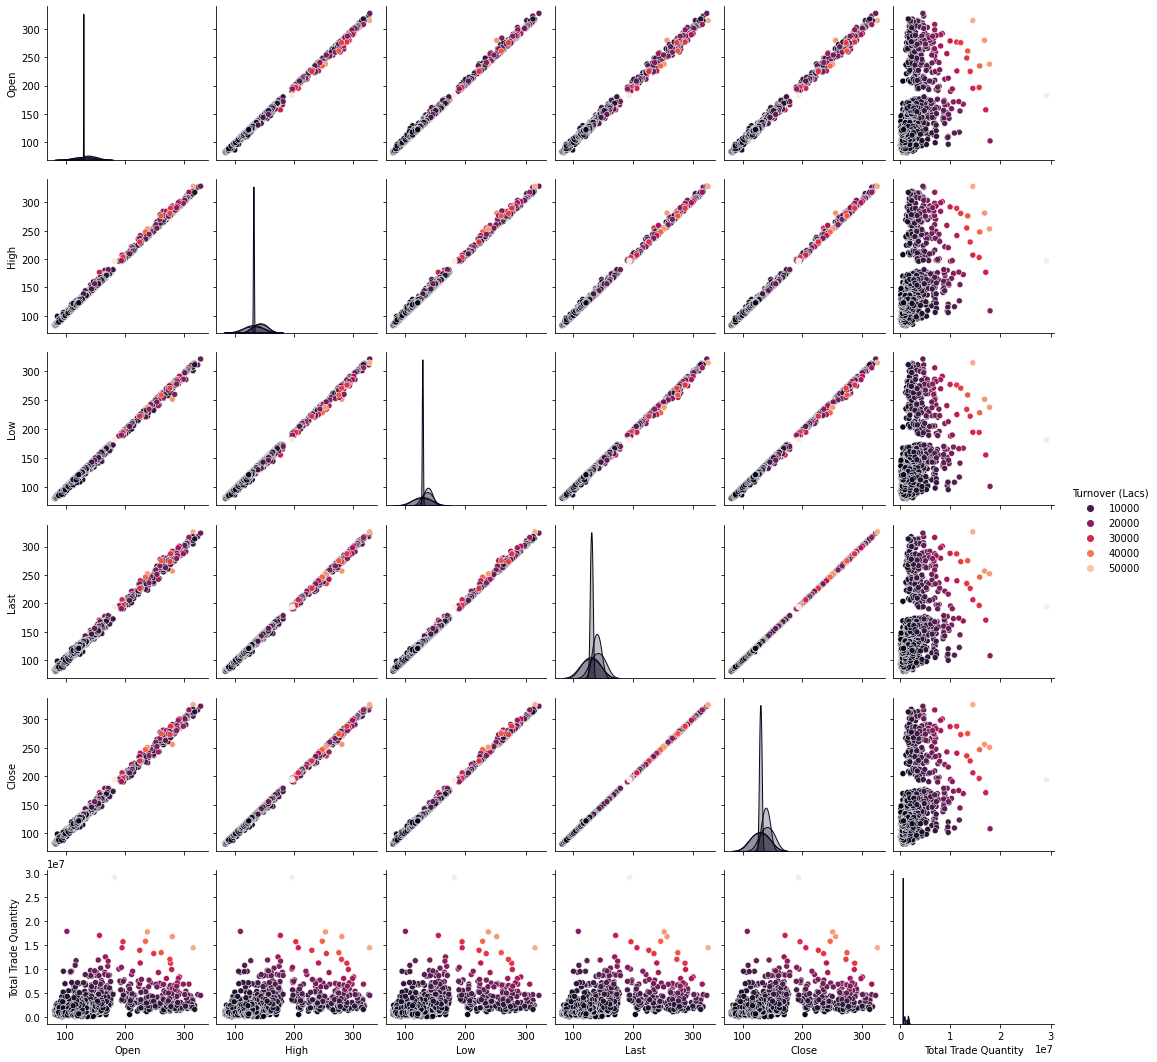

In [8]:
sns.pairplot(stock_df, hue="Turnover (Lacs)", palette="rocket")
plt.show()

In [9]:
df_close = stock_df.reset_index()['Close'] 
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

- Let us plot the close value graph using pyplot

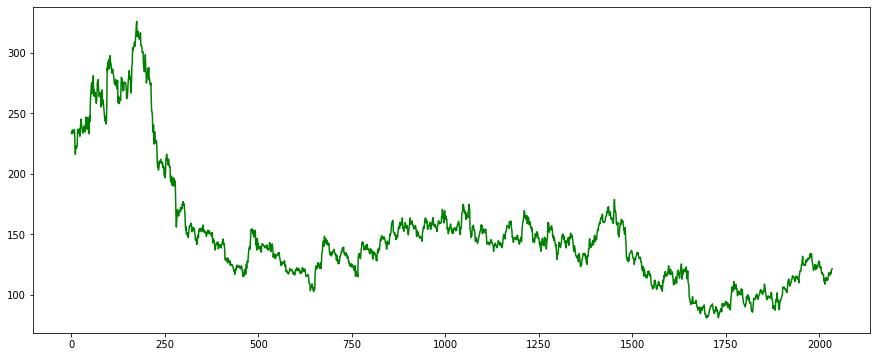

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(df_close, c="g")
plt.show()

- Let us plot the high value graph using pyplot

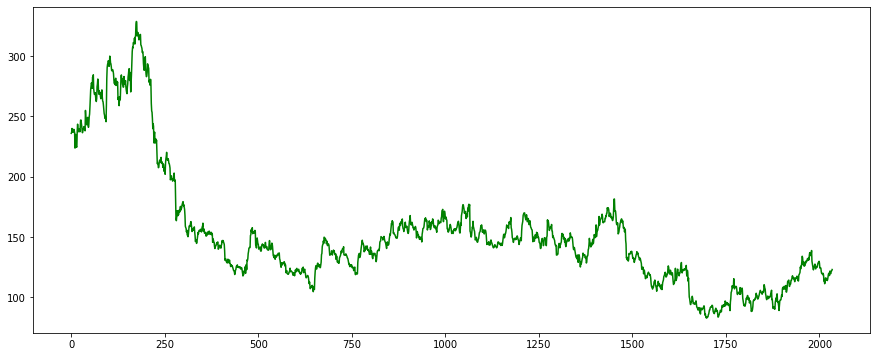

In [11]:
plt.figure(figsize=(15, 6))
df_high=stock_df.reset_index()['High']
plt.plot(df_high, c='g')
plt.show()

- Since LSTM are sensitibe to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1, 1))

In [13]:
df_high.shape

(2035, 1)

In [14]:
df_high

array([[0.62268754],
       [0.62614353],
       [0.6391543 ],
       ...,
       [0.15917869],
       [0.15938199],
       [0.16344786]])

#Train Test Split

In [15]:
training_size = int(len(df_high) * 0.75 )
test_size=len(df_high) - training_size
train_data, test_data = df_high[0:training_size,:], df_high[training_size:len(df_high), :1]

In [16]:
training_size, test_size

(1526, 509)

#Data Preprocessing

In [17]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step - 1 ) :
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i+time_step, 0])
  return np.array(dataX), np.array(dataX)

In [18]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

#LSTM
- Reshape the input to be [ samples, time steps, features] which is the requirement of LSTM

In [19]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1) 
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1) 

In [20]:
print(x_train.shape) 
print(y_train.shape) 

(1425, 100, 1)
(1425, 100)


In [21]:
print(x_test.shape)
print(y_test.shape)

(408, 100, 1)
(408, 100)


- Import required modules for the stacked LSTM

In [22]:
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

- Create LSTM Module

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 18s 431ms/step - loss: 0.0440 - val_loss: 0.0084
Epoch 2/100
23/23 [==============================] - 10s 435ms/step - loss: 0.0100 - val_loss: 0.0065
Epoch 3/100
23/23 [==============================] - 9s 382ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 4/100
23/23 [==============================] - 9s 384ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 5/100
23/23 [==============================] - 10s 425ms/step - loss: 0.0064 - val_loss: 0.0027
Epoch 6/100
23/23 [==============================] - 9s 381ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 7/100
23/23 [==============================] - 10s 452ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 8/100
23/23 [==============================] - 15s 628ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 9/100
23/23 [==============================] - 9s 389ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 10/100
23/23 [==============================] - 9s 381ms/step - loss: 0.0038 - v

In [26]:
# Let predict and check performance matrirx
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [27]:
# Transform back to original form 
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plotting graph according to train and test data

- Plotting

In [29]:
# Shift train prediction for plotting 
look_back=100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, : ] = train_predict

# Shifting test prediction for plotting
testPredictplot = np.empty_like(df_high)
testPredictplot[:,:] = np.nan
testPredictplot[len(train_predict) + (look_back * 2) + 1 : len(df_high) - 1, :  ] = test_predict

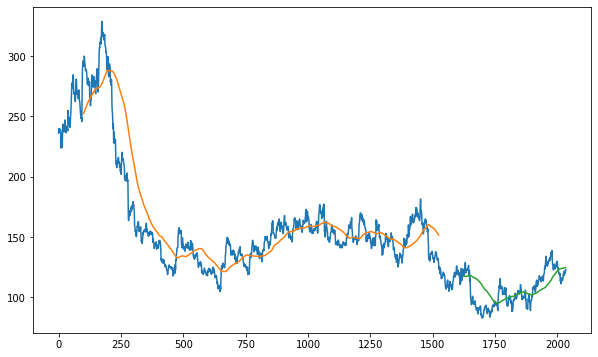

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data


In [30]:
# Plot baseline and predictions
plt.figure(figsize=(10, 6))

plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictplot)
plt.show()

print("Green indicates the Predicted Data")
print("Blue indicates the Complete Data")
print("Orange indicates the Train Data")

In [31]:
# predict the next 28 days stock price 
len(test_data)
x_test.shape

(408, 100, 1)

In [32]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

# Predicting values for next 30 days

In [33]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.17089504]
101
1 day input [0.13254727 0.13397032 0.13356373 0.13498679 0.14108559 0.13498679
 0.12644847 0.12685505 0.12482212 0.14515145 0.1467778  0.15003049
 0.15368977 0.17198618 0.16548079 0.17625534 0.17564546 0.19129904
 0.20817239 0.20309006 0.18479366 0.17930474 0.1896727  0.17483228
 0.17849156 0.17645863 0.18540354 0.18377719 0.19190892 0.18987599
 0.19028258 0.19394186 0.20004066 0.19638138 0.19495832 0.20349665
 0.19597479 0.21162838 0.22036999 0.20979874 0.21528766 0.21589754
 0.21610083 0.22748526 0.19150234 0.1833706  0.17340923 0.16751372
 0.1622281  0.17056312 0.17462899 0.17930474 0.18174426 0.16853019
 0.16548079 0.1742224  0.1713763  0.17300264 0.17157959 0.17767839
 0.18459036 0.18702988 0.18987599 0.19109575 0.18581012 0.17015654
 0.16751372 0.16974995 0.16609067 0.15531612 0.15003049 0.15064037
 0.14860744 0.14596463 0.15043708 0.14413499 0.12441553 0.12827811
 0.11547062 0.12034966 0.13478349 0.13498679 0.12868469 0.13295385
 0.12807481 0.12624517 0.13051433

In [35]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 129)

In [36]:
day_new.shape

(100,)

In [37]:
ds3 = df_high.tolist()
ds3.extend(lst_output)

len(df_high)

2035

- Graph of actual values in last 100 days

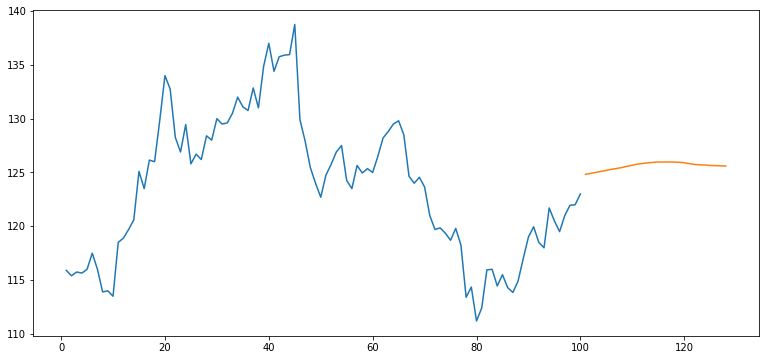

In [38]:
plt.figure(figsize=(13, 6))

plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

plt.show()

- Graph of predicted values for next 30 days

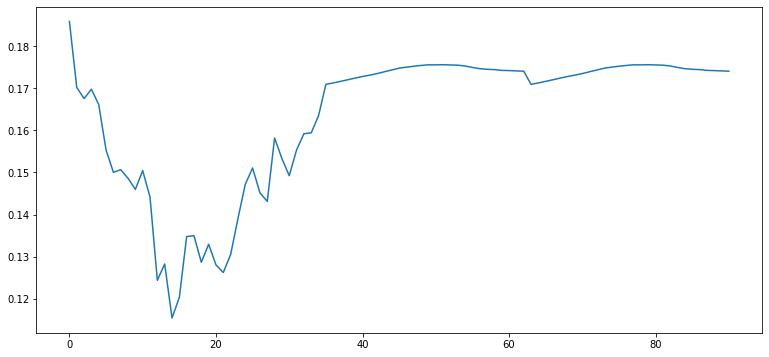

In [39]:
plt.figure(figsize=(13, 6))

de3 = df_high.tolist()
ds3.extend(lst_output)
plt.plot(ds3[2000:])

plt.show()

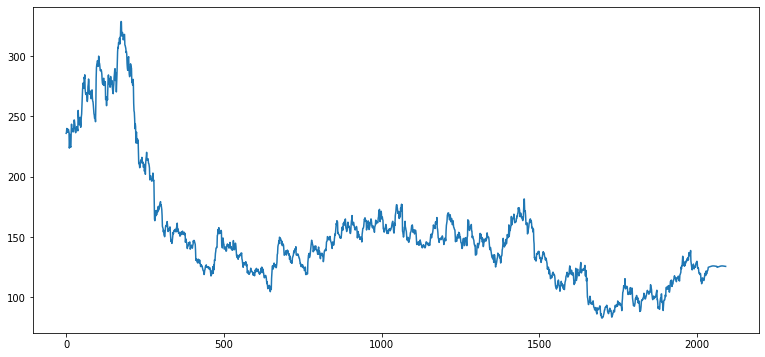

In [40]:
plt.figure(figsize=(13,6))

ds3=scaler.inverse_transform(ds3).tolist()
plt.plot(ds3)

plt.show()